In [1]:
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from mpl_toolkits.basemap import Basemap

import numpy as np
import pandas as pd

# Loading

In [2]:
TRAIN_PATH = "data/download/train.csv"
TEST_PATH = "data/download/test.csv"

PROC_DIR = "data/processed_data"

In [3]:
# number of rows of train
!wc -l {TRAIN_PATH}

 55423856 data/download/train.csv


In [4]:
# number of rows of test
!wc -l {TEST_PATH}

    9914 data/download/test.csv


In [5]:
# let's read the first few rows
train_df = pd.read_csv(TRAIN_PATH, nrows=5)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
key                  5 non-null object
fare_amount          5 non-null float64
pickup_datetime      5 non-null object
pickup_longitude     5 non-null float64
pickup_latitude      5 non-null float64
dropoff_longitude    5 non-null float64
dropoff_latitude     5 non-null float64
passenger_count      5 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 400.0+ bytes


In [8]:
pd.to_datetime(train_df["key"])

0   2009-06-15 17:26:21.000000100
1   2010-01-05 16:52:16.000000200
2   2011-08-18 00:35:00.000000490
3   2012-04-21 04:30:42.000000100
4   2010-03-09 07:51:00.000000135
Name: key, dtype: datetime64[ns]

In [9]:
pd.to_datetime(train_df["pickup_datetime"])

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

Columns `key` and and `pickup_datetime` seem to be the same timestamp, except that `pickup_datetime` has second precision whereas `key` has nano second precision. `key` is used to uniquely identify each row and hence not important for data analysis and modeling. We will drop this column in the train set. `key` is still needed for the test set to write out the Kaggle submission file.

`train.csv` has a large number of rows (more than 55 million) so it may take a long time to read it into a dataframe. To quickly read the data and reduce its size, we follow this post: https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows .

In [10]:
def load_nyc_taxi_fare(path, col_types, chunksize=None):
    chunk_iter = pd.read_csv(path, usecols=col_types.keys(), dtype=col_types, chunksize=chunksize)
    
    if chunksize is None:
        chunk_iter["pickup_datetime"] = pd.to_datetime(chunk_iter["pickup_datetime"], 
                                                       utc=True, format="%Y-%m-%d %H:%M:%S UTC")
        return chunk_iter
    
    df_list = []
    # use tqdm to monitor progress
    # It would take extremely long time if format were not used.
    for df_chunk in tqdm(chunk_iter):
        df_chunk["pickup_datetime"] = pd.to_datetime(df_chunk["pickup_datetime"], 
                                                     utc=True, format="%Y-%m-%d %H:%M:%S UTC")
        df_list.append(df_chunk)
    return pd.concat(df_list)

In [11]:
train_types = {"fare_amount": "float32",
              "pickup_datetime": "str", 
              "pickup_longitude": "float32",
              "pickup_latitude": "float32",
              "dropoff_longitude": "float32",
              "dropoff_latitude": "float32",
              "passenger_count": "uint8"}
train_df = load_nyc_taxi_fare(TRAIN_PATH, train_types, chunksize=5_000_000)
train_df.head()

12it [05:32, 20.69s/it]


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


In [12]:
train_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [13]:
test_types = train_types.copy()
test_types.pop("fare_amount")
test_types["key"] = "str"

test_df = load_nyc_taxi_fare(TEST_PATH, test_types)
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1


In [14]:
test_df.shape

(9914, 7)

# Cleaning and EDA

In [15]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,8.077921e+00,-3.875290e+01,1.937328e+01,-3.875261e+01,1.937341e+01,1.685380e+00
std,2.055127e+01,2.556202e+01,1.414234e+01,2.553839e+01,1.412191e+01,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


Is there any Null?

In [16]:
train_df.isna().sum()

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

Since the number of rows containing null is very small compared to the total number of rows, we decide to drop them.

In [17]:
print("shape before dropping:", train_df.shape)
train_df = train_df.dropna(axis=0, how="any")
print("shape after dropping:", train_df.shape)

shape before dropping: (55423856, 7)
shape after dropping: (55423480, 7)


## Cleaning up `fare_amount`

There are negative fare amounts. Let's count how there are in the training set.

In [18]:
print("Number of negative values of fare_amount: %d " % (train_df["fare_amount"] < 0).sum())

Number of negative values of fare_amount: 2454 


Since negative values of `fare_amount` do not make sense, we will drop them.

In [19]:
print("Shape before dropping:", train_df.shape)
train_df = train_df[train_df["fare_amount"] >= 0]
print("Shape after dropping:", train_df.shape)

Shape before dropping: (55423480, 7)
Shape after dropping: (55421026, 7)


Very large values of `fare_amount` may also be problematic. Let's look the histogram.

Text(0.5,1,'data with fare_amount < 200')

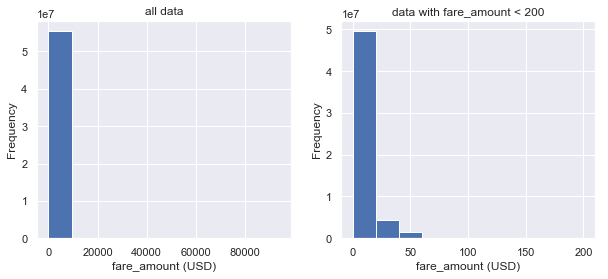

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
train_df["fare_amount"].plot(kind="hist", ax=ax[0])
ax[0].set_xlabel("fare_amount (USD)")
ax[0].set_title("all data")

train_df.loc[train_df["fare_amount"] < 200, "fare_amount"].plot(kind="hist", ax=ax[1])
ax[1].set_xlabel("fare_amount (USD)")
ax[1].set_title("data with fare_amount < 200")

In [21]:
for fare in [100, 200, 500, 1000, 5000, 10000]:
    print("Number of rows with fare_amount greater than $%d is %d" %(fare, (train_df["fare_amount"] > fare).sum()))

Number of rows with fare_amount greater than $100 is 20875
Number of rows with fare_amount greater than $200 is 1654
Number of rows with fare_amount greater than $500 is 43
Number of rows with fare_amount greater than $1000 is 12
Number of rows with fare_amount greater than $5000 is 4
Number of rows with fare_amount greater than $10000 is 3


There are few values greater than $200. Latter we will see if these expensive trips correspond to long distances and decide whether we will drop them.

## Clean up Pickup and dropoff location data

In [22]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542103e+07,5.542103e+07,5.542103e+07,5.542103e+07,5.542103e+07,5.542103e+07
mean,8.078541e+00,-3.875488e+01,1.937427e+01,-3.875433e+01,1.937427e+01,1.685380e+00
std,2.055114e+01,2.556268e+01,1.414270e+01,2.553895e+01,1.412200e+01,1.327654e+00
min,0.000000e+00,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


Latitude ranges from -90$^o$ to 90$^o$ and longitude from -180$^o$ to 180$^o$. Values outside these ranges do not make sense and we will drop them.

In [23]:
def drop_wrong_gps_coor(df):
    print("Shape before dropping:", df.shape)
    df = df[(df["pickup_longitude"] >= -180) & (df["pickup_longitude"] <= 180)]
    df = df[(df["dropoff_longitude"] >= -180) & (df["dropoff_longitude"] <= 180)]
    
    df = df[(df["pickup_latitude"] >= -90) & (df["pickup_latitude"] <= 90)]
    df = df[(df["dropoff_latitude"] >= -90) & (df["dropoff_latitude"] <= 90)]
    print("Shape after dropping:", df.shape)
    return df

In [24]:
train_df = drop_wrong_gps_coor(train_df)

Shape before dropping: (55421026, 7)
Shape after dropping: (55418281, 7)


In [25]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.541828e+07,5.541828e+07,5.541828e+07,5.541828e+07,5.541828e+07,5.541828e+07
mean,8.078673e+00,-3.875046e+01,1.937523e+01,-3.875046e+01,1.937523e+01,1.685373e+00
std,2.055150e+01,2.494473e+01,1.257314e+01,2.494466e+01,1.257294e+01,1.327624e+00
min,0.000000e+00,-1.717973e+02,-7.783388e+01,-1.739576e+02,-7.435461e+01,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,1.699728e+02,8.974216e+01,1.699728e+02,8.981667e+01,2.080000e+02


By googling we know that the geo-coordinate of the center of New York City is (40.7128$^o$ N, 74.0060$^o$ W) which means `latitute` = 40.7128$^o$ and `longitude` = -74.0060$^o$. We expect the pickup and dropoff coordinates in the train data set vary by one or two degrees at most from the center. However, the min and max values of the `longitude` and `latitude` are very extreme. 

We will focus on the region around New York City. We follow this post: https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration and define a bounding box from GPS coordinates in the test set.

In [26]:
LON_MIN = np.min([test_df["pickup_longitude"].min(), test_df["dropoff_longitude"].min()])
LON_MAX = np.max([test_df["pickup_longitude"].max(), test_df["dropoff_longitude"].max()])

LAT_MIN = np.min([test_df["pickup_latitude"].min(), test_df["dropoff_latitude"].min()])
LAT_MAX = np.max([test_df["pickup_latitude"].max(), test_df["dropoff_latitude"].max()])

print("LON_MIN = %0.5f" % LON_MIN)
print("LON_MAX = %0.5f" % LON_MAX)
print("LAT_MIN = %0.5f" % LAT_MIN)
print("LAT_MAX = %0.5f" % LAT_MAX)

LON_MIN = -74.26324
LON_MAX = -72.98653
LAT_MIN = 40.56897
LAT_MAX = 41.70956


Let's see how many data points are outside the bounding box.

In [27]:
def is_pickup_inside(df, lon_min, lon_max, lat_min, lat_max):
    lat_inside = (df["pickup_latitude"] >= lat_min) & (df["pickup_latitude"] <= lat_max)
    lon_inside = (df["pickup_longitude"] >= lon_min) & (df["pickup_longitude"] <= lon_max)
    return lat_inside & lon_inside

def is_dropoff_inside(df, lon_min, lon_max, lat_min, lat_max):
    lat_inside = (df["dropoff_latitude"] >= lat_min) & (df["dropoff_latitude"] <= lat_max)
    lon_inside = (df["dropoff_longitude"] >= lon_min) & (df["dropoff_longitude"] <= lon_max)
    return lat_inside & lon_inside

def is_inside(df, lon_min, lon_max, lat_min, lat_max):
    """both pickup and dropoff are inside"""
    p_in = is_pickup_inside(df, lon_min, lon_max, lat_min, lat_max)
    d_in = is_dropoff_inside(df, lon_min, lon_max, lat_min, lat_max)
    return p_in & d_in

In [28]:
inside = is_inside(train_df, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX)
outside = ~inside
print("%0.3f%% of points outside the bounding box" % (outside.mean() * 100))

2.135% of points outside the bounding box


Let's increase the bounding box a little bit to include more points in the box.

In [29]:
for deg in [0.05, 0.1, 0.2, 0.5, 1, 2, 5]:
    lat_min = LAT_MIN - deg / 2
    lat_max = LAT_MAX + deg / 2
    lon_min = LON_MIN - deg / 2
    lon_max = LON_MAX + deg / 2
    
    inside = is_inside(train_df, lon_min, lon_max, lat_min, lat_max)
    outside = ~inside
    print("When increasing each side by %0.3f deg, %0.3f%% of points are outside." % (deg, outside.mean()*100))

When increasing each side by 0.050 deg, 2.127% of points are outside.
When increasing each side by 0.100 deg, 2.122% of points are outside.
When increasing each side by 0.200 deg, 2.116% of points are outside.
When increasing each side by 0.500 deg, 2.108% of points are outside.
When increasing each side by 1.000 deg, 2.100% of points are outside.
When increasing each side by 2.000 deg, 2.083% of points are outside.
When increasing each side by 5.000 deg, 2.073% of points are outside.


When increasing the boudning box, not a lot of points actually move inside. This means that most of the points outside the box are really far away. There are about 2% of the points having both pickup and dropoff locations are far from New York City. Let's look at them on the map.

In [30]:
def create_nyc_map(ax, lon_min, lon_max, lat_min, lat_max, alpha=1.):
    # projection="cyl" or projection="lcc"
    bmap = Basemap(projection="cyl", resolution="h", ax=ax,
                   llcrnrlat=lat_min, urcrnrlat=lat_max, 
                   llcrnrlon=lon_min, urcrnrlon=lon_max,
                   lat_0=(lat_min + lat_max) / 2, lon_0=(lon_min + lon_max) / 2)
    
    bmap.drawmapboundary(fill_color='aqua', ax=ax, zorder=0)
    bmap.fillcontinents(color="coral", lake_color='aqua', alpha=alpha, ax=ax, zorder=1)
    bmap.drawstates(color='gray', ax=ax, zorder=2)
    
    return bmap

def plot_coor_on_map(bmap, lons, lats, marker="o", s=1, c="k", label=None):
    bmap.scatter(lons, lats, latlon=True, marker=marker, s=s, c=c, zorder=3, label=label)
    return bmap

train_df_small shape (1108366, 7)


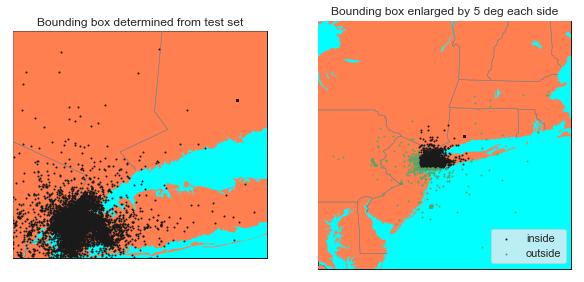

In [31]:
train_df_small = train_df.sample(frac=0.02, random_state=210)
print("train_df_small shape", train_df_small.shape)
inside_idx = is_pickup_inside(train_df_small, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX)

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

bmap = create_nyc_map(ax[0], LON_MIN, LON_MAX, LAT_MIN, LAT_MAX)
bmap = plot_coor_on_map(bmap,  
                        train_df_small["pickup_longitude"].values,
                        train_df_small["pickup_latitude"].values,
                        marker="o", s=1, c="k", label=None)
ax[0].set_title("Bounding box determined from test set")

bmap = create_nyc_map(ax[1], LON_MIN-2.5, LON_MAX+2.5, LAT_MIN-2.5, LAT_MAX+2.5)
bmap = plot_coor_on_map(bmap,  
                        train_df_small.loc[inside_idx, "pickup_longitude"].values,
                        train_df_small.loc[inside_idx, "pickup_latitude"].values,
                       marker="o", s=1, c="k", label="inside")
bmap = plot_coor_on_map(bmap,  
                        train_df_small.loc[~inside_idx, "pickup_longitude"].values,
                        train_df_small.loc[~inside_idx, "pickup_latitude"].values,
                       marker="o", s=1, c="g", label="outside")
ax[1].set_title("Bounding box enlarged by 5 deg each side")
ax[1].legend()

The area of the enlarged bounding box is really large. Since we are interested in taxi rides near New York City, we will use the bounding box given by the test set enlarged by 1 degree each side.

In [32]:
inside_idx = is_inside(train_df, LON_MIN-0.5, LON_MAX+0.5, LAT_MIN-0.5, LAT_MAX+0.5)
print("Shape before dropping:", train_df.shape)
train_df = train_df[inside_idx]
print("Shape after dropping:", train_df.shape)

Shape before dropping: (55418281, 7)
Shape after dropping: (54254567, 7)


Text(0.5,1,'Bounding box enlarged by 1 deg each side')

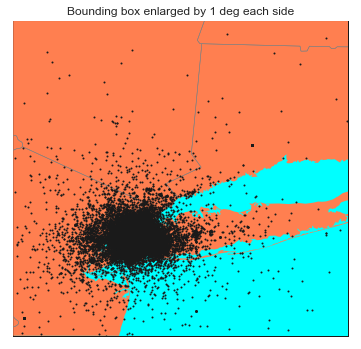

In [33]:
train_df_small = train_df.sample(frac=0.1, random_state=210)
sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

bmap = create_nyc_map(ax, LON_MIN-0.5, LON_MAX+0.5, LAT_MIN-0.5, LAT_MAX+0.5)
bmap = plot_coor_on_map(bmap,  
                        train_df_small["pickup_longitude"].values,
                        train_df_small["pickup_latitude"].values,
                        marker="o", s=1, c="k", label=None)
ax.set_title("Bounding box enlarged by 1 deg each side")

There are a lot of points on water. This makes little sense. Let's see if this also happens for the test set.

Text(0.5,1,'Pickup coordinates of test set')

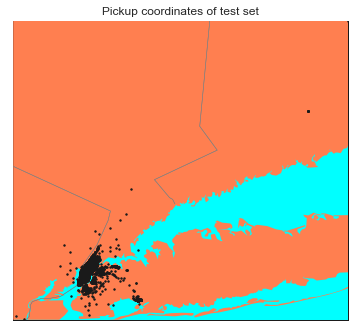

In [34]:
sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

bmap = create_nyc_map(ax, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX)
bmap = plot_coor_on_map(bmap,  
                        test_df["pickup_longitude"].values,
                        test_df["pickup_latitude"].values,
                        marker="o", s=2, c="k", label=None)
ax.set_title("Pickup coordinates of test set")

It happens the test set but rare. Points on water are much closer to shore which may be acceptable. Before deciding whether to remove all the taxi rides which start (pickup) and/or end (dropoff) on water from the training set, let's see if the target variable `fare_amount` is related to whether the pickup or dropoff coordinate in on water. 

In [35]:
def is_on_land(lons, lats):
    #bm = Basemap(projection='cyl', resolution="h", )
    
    lon_min = np.min(lons) - 0.01
    lon_max = np.max(lons) + 0.01
    
    lat_min = np.min(lats) - 0.01
    lat_max = np.max(lats) + 0.01
    
    lon_0 = (lon_min + lon_max) / 2
    lat_0 = (lat_min + lat_max) / 2
    
    # projection="cyl" or projection="lcc"
    bm = Basemap(projection="cyl", resolution="h", 
                 llcrnrlat=lat_min, urcrnrlat=lat_max, 
                 llcrnrlon=lon_min, urcrnrlon=lon_max,
                 lon_0=lon_0, lat_0=lat_0)
    
    xpt, ypt = bm(lons, lats)
    vec_is_land = np.vectorize(bm.is_land)
    return vec_is_land(xpt, ypt)

def is_pickup_on_land(df):
    return is_on_land(df["pickup_longitude"].values, df["pickup_latitude"].values)

def is_dropoff_on_land(df):
    return is_on_land(df["dropoff_longitude"].values, df["dropoff_latitude"].values)

def is_both_pickup_or_dropoff_on_land(df):
    return is_pickup_on_land(df) & is_dropoff_on_land(df)

Determining whether pickup and dropoff locations are on land or water takes a long time. So will do that for only 2% of the training data.

In [36]:
create_csv = False

if create_csv:
    train_df_small = train_df.sample(frac=0.02, random_state=210)
    train_df_small["on_land"] = is_both_pickup_or_dropoff_on_land(train_df_small)
    train_df_small.to_csv(os.path.join(PROC_DIR, "train_df_small.csv"))
    print(train_df_small.shape)
    
else:
    train_df_small = pd.read_csv(os.path.join(PROC_DIR, "train_df_small.csv"))
    print(train_df_small.shape)

(1085091, 9)


In [37]:
print("There are %0.3f%% of points on water." % ((1 - train_df_small["on_land"].mean())*100) )

There are 0.338% of points on water.


Text(0.5,1,'On Water')

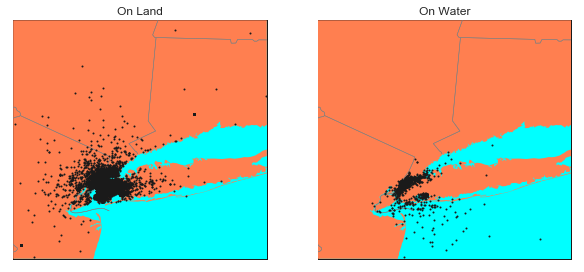

In [38]:
on_land = train_df_small["on_land"]
on_water = ~on_land

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

bmap = create_nyc_map(ax[0], LON_MIN-0.5, LON_MAX+0.5, LAT_MIN-0.5, LAT_MAX+0.5)
bmap = plot_coor_on_map(bmap,  
                        train_df_small.loc[on_land, "pickup_longitude"].values,
                        train_df_small.loc[on_land, "pickup_latitude"].values,
                        marker="o", s=1, c="k", label=None)
ax[0].set_title("On Land")

bmap = create_nyc_map(ax[1], LON_MIN-0.5, LON_MAX+0.5, LAT_MIN-0.5, LAT_MAX+0.5)
bmap = plot_coor_on_map(bmap,  
                        train_df_small.loc[on_water, "pickup_longitude"].values,
                        train_df_small.loc[on_water, "pickup_latitude"].values,
                        marker="o", s=1, c="k", label=None)
ax[1].set_title("On Water")

How is `fare_amount` distributed among normal taxi trips and taxi trips which start and/or end up in water?

Text(0,0.5,'Density')

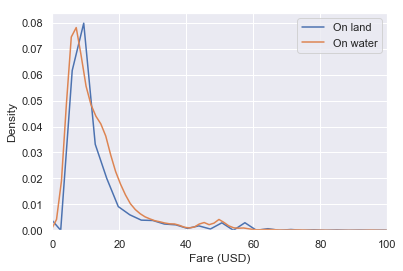

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.kdeplot(train_df_small.loc[train_df_small["on_land"], "fare_amount"], ax=ax, label="On land")
sns.kdeplot(train_df_small.loc[~train_df_small["on_land"], "fare_amount"], ax=ax, label="On water")
ax.set_xlim([0, 100])
ax.set_xlabel("Fare (USD)")
ax.set_ylabel("Density")

The distribution of fare does not seem to be affected by whether pickup and/or dropoff locations are on land or on water. 

Let's compare distance distributions of normal trips and trips start and/or end up in water. The function below is based on https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula

In [40]:
# return distance in kilometer
def distance(lon1, lat1, lon2, lat2):
    lon1_rad = np.radians(lon1)
    lat1_rad = np.radians(lat1)
    lon2_rad = np.radians(lon2)
    lat2_rad = np.radians(lat2)
    
    a = 0.5 - 0.5*np.cos(lat2_rad - lat1_rad) + np.cos(lat1_rad)*np.cos(lat2_rad)*(1 - np.cos(lon2_rad - lon1_rad))*0.5
    return 12742 * np.arcsin(np.sqrt(a)) 

In [41]:
train_df_small["distance"] = distance(train_df_small["pickup_longitude"], train_df_small["pickup_latitude"],
                                train_df_small["dropoff_longitude"], train_df_small["dropoff_latitude"])

Text(0,0.5,'Density')

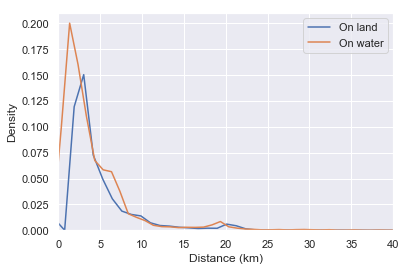

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.kdeplot(train_df_small.loc[train_df_small["on_land"], "distance"], ax=ax, label="On land")
sns.kdeplot(train_df_small.loc[~train_df_small["on_land"], "distance"], ax=ax, label="On water")
ax.set_xlim([0, 40])
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Density")

The distributions don't look that much different.

Anyway, there are only about 0.3% of the taxi rides having pickup and/or dropoff locations on water and determining them are very computationally expensive. So we will ignore them. 

In [55]:
del train_df_small

## Clean up number of passenger

In [43]:
print("min", train_df["passenger_count"].min())
print("max", train_df["passenger_count"].max())

min 0
max 208


In [44]:
for c in [5, 6, 7, 10, 20, 50, 100]:
    print("Number of rows with passenger_count greater than %d is %d" %(c, (train_df["passenger_count"] > c).sum()))

Number of rows with passenger_count greater than 5 is 1150268
Number of rows with passenger_count greater than 6 is 65
Number of rows with passenger_count greater than 7 is 52
Number of rows with passenger_count greater than 10 is 24
Number of rows with passenger_count greater than 20 is 24
Number of rows with passenger_count greater than 50 is 24
Number of rows with passenger_count greater than 100 is 24


We decide to remove rows having `passenger_count` greater than 6.

In [45]:
print("shape before dropping", train_df.shape)
train_df = train_df[train_df["passenger_count"] <= 6]
print("shape after dropping", train_df.shape)

shape before dropping (54254567, 7)
shape after dropping (54254502, 7)


[Text(0,0,'0'),
 Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6')]

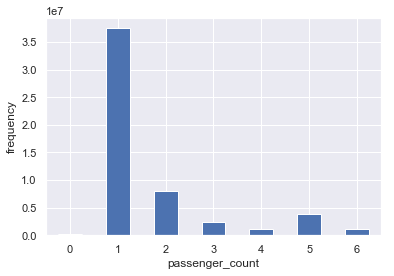

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
df_tmp = train_df["passenger_count"].value_counts().sort_index()
df_tmp.plot(kind="bar", ax=ax)

ax.set_xlabel("passenger_count")
ax.set_ylabel("frequency")

xticklabels = df_tmp.index.to_list()
ax.set_xticklabels(xticklabels, rotation=0)

## Relationship between distance and fare

In [49]:
train_df["distance"] = distance(train_df["pickup_longitude"], train_df["pickup_latitude"],
                                train_df["dropoff_longitude"], train_df["dropoff_latitude"])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.scatterplot(data=train_df, x="distance", y="fare_amount", ax=ax)
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Fare (USD)")

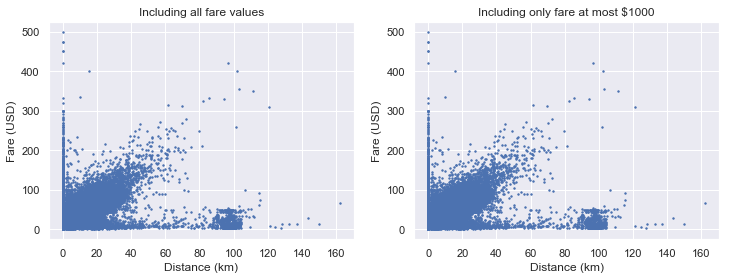

In [71]:
df_small = train_df.sample(frac=0.1, random_state=210)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax[0].scatter(df_small["distance"], df_small["fare_amount"], s=2)
ax[0].set_xlabel("Distance (km)")
ax[0].set_ylabel("Fare (USD)")
ax[0].set_title("Including all fare values")

df_small = df_small[df_small["fare_amount"] <= 1000]
ax[1].scatter(df_small["distance"], df_small["fare_amount"], s=2)
ax[1].set_xlabel("Distance (km)")
ax[1].set_ylabel("Fare (USD)")
ax[1].set_title("Including only fare at most $1000")

del df_small

In [67]:
print("Number of points with fare_amount greater than $500 is %d" % (train_df["fare_amount"] > 500).sum())

Number of points with fare_amount greater than $500 is 21


Data points having `fare_amount` greater than $500 are rare and likely to be outliers. So we decide to drop them.

In [68]:
print("Shape before dropping", train_df.shape)
train_df = train_df[train_df["fare_amount"] <= 500]
print("Shape after dropping", train_df.shape)

Shape before dropping (54254502, 8)
Shape after dropping (54254481, 8)


There seems to be many taxi trips with zero distance.

In [72]:
print("There are %0.3f percent of rows having distance zero." % ((train_df["distance"] == 0).mean()*100))

There are 38.762 percent of rows having distance zero.


That's a lot!

Let's compare fare distributions for the cases zero and nonzero distances. 

Text(0.5,1,'Zoom-in at small fare_amount')

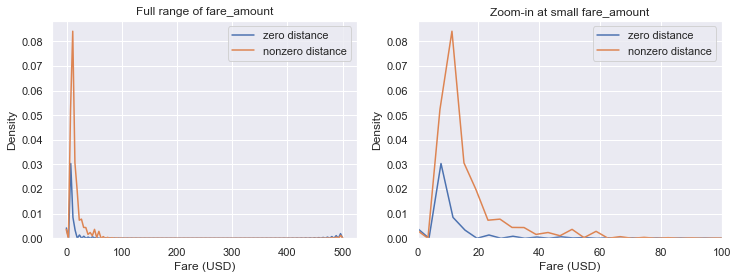

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.kdeplot(train_df.loc[train_df["distance"] == 0, "fare_amount"], ax=ax[0], label="zero distance")
sns.kdeplot(train_df.loc[train_df["distance"] > 0, "fare_amount"], ax=ax[0], label="nonzero distance")

ax[0].set_xlabel("Fare (USD)")
ax[0].set_ylabel("Density")
ax[0].set_title("Full range of fare_amount")

sns.kdeplot(train_df.loc[train_df["distance"] == 0, "fare_amount"], ax=ax[1], label="zero distance")
sns.kdeplot(train_df.loc[train_df["distance"] > 0, "fare_amount"], ax=ax[1], label="nonzero distance")

ax[1].set_xlim([0, 100])
ax[1].set_xlabel("Fare (USD)")
ax[1].set_ylabel("Density")
ax[1].set_title("Zoom-in at small fare_amount")

## Save to csv

In [46]:
train_df.to_csv(os.path.join(PROC_DIR, "train_df.csv"))